In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [10]:
data = pd.read_excel("https://www.sharkattackfile.net/spreadsheets/GSAF5.xls")

### Preparation of the database

In [12]:
# hl_df stands for 'High Level DataFrame'
# We can use this DataFrame for analysis on a higher level, like checking countries, years, sex of the victims and their activies
# We can create another dataframe for more specific analysis, like months and states...

hl_df = data.drop(columns=[
    'Date',
    'State',
    'Location',
    'Name',
    'Unnamed: 11',
    'Time',
    'Case Number.1',
    'Source',
    'pdf',
    'href formula',
    'href',
    'original order',
    'Unnamed: 21',
    'Unnamed: 22'])

In [13]:
hl_df.rename(columns={
    'Type' : 'type',
    'Country' : 'country',
    'Activity' : 'activity',
    'Sex' : 'sex',
    'Age' : 'age',
    'Injury' : 'injury',
    'Species ' : 'size',
    'Year' : 'year'
    
}, inplace=True)

#changed Species and removed the extra space at the end

In [14]:
col_order = [
    'year',
    'country',
    'sex',
    'age',
    'activity',
    'injury',
    'type',
    'size'
]

hl_df = hl_df[col_order]

### SARA

In [16]:
#harmonisisng injury into 3 categories
hl_df['injury'].fillna('Unknown', inplace = True)
hl_df.loc[hl_df['injury'].str.contains('fatal|FATAL|bitten in two|Body was not recovered|Human remains|Torso recovered', case=False, na=False), 'injury'] = 'Fatal'
hl_df.loc[hl_df['injury'].str.contains('bitten|injured|severed|puncture|injury|nipped|gashed|broke injuries|bite|scavenged|slashed|ripped|bit|lost|major injuries', case=False, na=False), 'injury'] = 'Dramatic'
hl_df.loc[hl_df['injury'].str.contains('survived|no injury|no details|lacerat|minor|recovered|abraded|bruised|broken', case=False, na=False), 'injury'] = 'Minor'
categories = ['Fatal', 'Dramatic', 'Minor']
hl_df['injury'] = hl_df['injury'].apply(lambda x: x if x in categories else 'Others')

In [17]:
#lowercase all the strings
hl_df['country'] = hl_df['country'].str.lower()

#Organising countries into Seas and Oceans
seas_oceans_dict = {
    'North Atlantic Ocean': 'usa|bahamas|mexico|panama|atlantic ocean|bermuda|canada|france|senegal|venezuela|sierra leone|dominican republic|barbados|turks & caicos|mid atlantic ocean|azores|el salvador|north atlantic ocean|portugal|guinea|cape verde|guyana|liberia|turks and caicos|iceland|ireland',
    'South Atlantic Ocean': 'brazil|fiji|south atlantic ocean|seychelles|uruguay|mid atlantic ocean|nigeria|argentina|namibia|ghana|equatorial guinea|cameroon',
    'Indian Ocean': 'australia|south africa|reunion|mozambique|india|indonesia|sri lanka|kenya|mauritius|tanzania|indian ocean|somalia|reunion island|maldives|maldive islands|ceylon',
    'Pacific Ocean': 'mexico|philippines|french polynesia|japan|pacific ocean|tonga|marshall islands|ecuador|samoa|costa rica|colombia|chile|madagascar|north pacific ocean|kiribati|american samoa|south pacific ocean|southwest pacific ocean|central pacific|peru',
    'Mediterranean Sea': 'italy|egypt|spain|croatia|greece|france|turkey|israel|libya|malta|tunisia|montenegro|lebanon|crete|mediterranean sea|cayman islands|monaco|cyprus|algeria|syria',
    'Caribbean Sea': 'cuba|panama|jamaica|costa rica|colombia|belize|caribbean sea|dominican republic|nicaragua|grenada|honduras|martinique|tobago|haiti|trinidad|west indies',
    'Solomon Sea': 'papua new guinea|solomon islands|vanuatu|new guinea|johnston island',
    'South China Sea': 'hong kong|indonesia|vietnam|thailand|china|taiwan|south korea|okinawa|malaysia',
    'Persian Gulf': 'iran|iraq|saudi arabia|persian gulf|united arab emirates|uae'
}

for sea, pattern in seas_oceans_dict.items():
    hl_df.loc[hl_df['country'].str.contains(pattern, case=False, na=False), 'country'] = sea

seas_oceans =list(seas_oceans_dict.keys())
hl_df['country'] = hl_df['country'].apply(lambda x: x if x in seas_oceans else 'not clarified')


hl_df.rename(columns={
    'country' : 'seas_oceans'
}, inplace=True)

### CAIQUE

In [19]:
#@title cleaning 'size'

clean_species = {
    r'(?i)^.*white shark.*$': 'white shark', # Carcharodon carcharias
    r'(?i)^.*requiem.*$': 'requiem sharks', # Order Carcharhiniformes:
                                             # contains bull shark, lemon shark, blacktip shark and whitetip reef
    r'(?i)^.*wobbeg.*$': 'wobbegong', # Family Orectolobidae, contains 12 species. These are small (~1m), carpet sharks
    r'(?i)^.*carpet.*$' : 'wobbegong',
    r'(?i)^.*blue pointer.*$': 'blue pointer', # Isurus oxyrinchus
    r'(?i)^.*shortfin.*$': 'blue pointer',
    r'(?i)^.*mako.*$' : 'blue pointer',
    r'(?i)^.*blue whaler.*$' : 'blue shark', # Prionace glauca
    r'(?i)^.*blue shark.*$' : 'blue shark',
    r'(?i)^.*blue nose.*$' : 'blue shark',
    r'(?i)^.*blue-nose.*$' : 'blue shark',
    r'(?i)^.*sand.*$': 'sand tiger', # Carcharias taurus
    r'(?i)^.*grey nurse.*$' : 'sand tiger',
    r'(?i)^.*ragged.*$' : 'sand tiger',
    r'(?i)^.*hammerhead.*$': 'hammerhead', # Family Sphyrnidae
    # r'(?i)^.*tiger.*$': 'tiger shark' #,
    r'(?i)^.*bull.*$': 'bull shark', # Carcharhinus leucas
    r'(?i)^.*leucas.*$' : 'sevengill shark',
    r'(?i)^.*zamb.*$' : 'bull shark',
    # Sometimes just zambi, or zambesi, or zambezi
    r'(?i)^.*blacktip reef.*$': 'blacktip reef', # Carcharhinus melanopterus
    r'(?i)^.*blacktip "reef".*$': 'blacktip reef',
    r'(?i)^.*blacktail reef.*$': 'blacktip reef',
    r'(?i)^.*blacktip shark.*$': 'blacktip shark', # Carcharhinus limbatus
    r'(?i)^.*blackfin.*$' : 'blacktip shark',
    r'(?i)^.*black-tipped.*$' : 'blacktip shark',
    r'(?i)^.*grey reef.*$': 'grey reef', # Carcharhinus amblyrhynchos
    r'(?i)^.*oceanic white.*$': 'whitetip shark', # Carcharhinus longimanus
    r'(?i)^.*whitetip shark.*$': 'whitetip shark',
    r'(?i)^.*lemon.*$': 'lemon shark', # Negaprion brevirostris
    r'(?i)^.*bronze.*$': 'copper shark', # Carcharhinus brachyurus
    r'(?i)^.*copper.*$' : 'copper shark',
    r'(?i)^.*narrowtooth.*$' : 'copper shark',
    r'(?i)^.*whaler shark.*$' : 'copper shark',
    r'(?i)^.*spinner.*$': 'spinner shark', # Carcharhinus brevipinna
    r'(?i)^.*cookie.*$': 'cookiecutter shark', # Isistius brasiliensis
    r'(?i)^.*nurse shark.*$': 'nurse shark', # Ginglymostoma cirratum
    r'(?i)^.*sickle.*$': 'sicklefin shark', # Negaprion acutidens
    r'(?i)^.*sharptooth.*$': 'sicklefin shark',
    r'(?i)^.*caribbean reef.*$': 'caribbean reef', # Carcharhinus perezi
    r'(?i)^.*seven.*$' : 'sevengill shark', # Notorynchus cepedianus
    r'(?i)^.*broadnose.*$' : 'sevengill shark',
    r'(?i)^.*7-gill.*$' : 'sevengill shark',
    r'(?i)^.*dog.*$' : 'dog shark',
    r'(?i)^.*bask.*$' : 'basking shark', # Cetorhinus maximus
    r'(?i)^.*whale shark.*$' : 'whale shark', # Rhyncodon typus
    r'(?i)^.*galapagos shark.*$' : 'galapagos shark', # Carcharhinus galapagensis
    r'(?i)^.*salmon.*$' : 'salmon shark', # Lamna ditropis
    r'(?i)^.*dusky.*$' : 'dusky shark', # Carcharhinus obscurus
    r'(?i)^.*obscur.*$' : 'dusky shark',
    r'(?i)^.*angel.*$' : 'angel shark',
    r'(?i)^.*questionable.*$' : 'questionable',
    r'(?i)^.*unconf.*$': 'shark involvement unconfirmed',
    r'(?i)^.*invalid.*$': 'invalid',
}

hl_df.replace(to_replace=clean_species, regex=True, inplace=True)

# We'll have tou courate tiger sharks separately because of sand tigers
tiger_shark = {
    r'(?i)^.*tiger shark.*$' : 'tiger shark'
}

hl_df['size'] = hl_df['size'].replace(tiger_shark, regex=True)

species_size = {
    'white shark': 'big',
    'requiem sharks': 'medium',
    'wobbegong': 'small',
    'blue pointer': 'medium',
    'blue shark': 'medium',
    'sand tiger': 'big',
    'hammerhead': 'big',
    'bull shark': 'big',
    'blacktip reef': 'medium',
    'blacktip shark': 'medium',
    'grey reef': 'medium',
    'whitetip shark': 'medium',
    'lemon shark': 'big',
    'copper shark': 'medium',
    'spinner shark': 'medium',
    'cookiecutter shark': 'small',
    'nurse shark': 'medium',
    'sicklefin shark': 'medium',
    'caribbean reef': 'medium',
    'sevengill shark': 'medium',
    'dog shark': 'small',
    'basking shark': 'big',
    'whale shark': 'big',
    'galapagos shark': 'medium',
    'salmon shark': 'big',
    'dusky shark': 'big',
    'angel shark': 'medium',
}

hl_df['size'].replace(to_replace=species_size, regex=True, inplace=True)

shark_sizes_feet = {
    "1' shark" : 'small',
    "2' shark" : 'small',
    "3' shark" : 'small',
    "4' shark" : 'small',
    "5' shark" : 'small',
    "6' shark" : 'small',
    "7' shark" : 'medium',
    "8' shark" : 'medium',
    "9' shark" : 'medium',
    "10' shark" : 'medium',
    "11' shark" : 'medium',
    "12' shark" : 'medium',
    "13' shark" : 'medium',
    "14' shark" : 'medium',
    "15' shark" : 'medium',
    "16' shark" : 'medium',
}

hl_df['size'].replace(to_replace=shark_sizes_feet, regex=True, inplace=True)

shark_sizes_feet_2 = {
    r"(?i)^.*1' .*$" : 'small',
    r"(?i)^.*2' .*$" : 'small',
    r"(?i)^.*3' .*$" : 'small',
    r"(?i)^.*4' .*$" : 'small',
    r"(?i)^.*5' .*$" : 'small',
    r"(?i)^.*6' .*$" : 'small',
    r"(?i)^.*small.*$" : 'small',
    r"(?i)^.*7' .*$" : 'medium',
    r"(?i)^.*8' .*$" : 'medium',
    r"(?i)^.*9' .*$" : 'medium',
    r"(?i)^.*10' .*$" : 'medium',
    r"(?i)^.*11' .*$" : 'medium',
    r"(?i)^.*12' .*$" : 'medium',
    r"(?i)^.*13' .*$" : 'medium',
    r"(?i)^.*14' .*$" : 'medium',
    r"(?i)^.*15' .*$" : 'medium',
    r"(?i)^.*16' .*$" : 'medium',
     r"(?i)^.*16' .*$" : 'medium',
    r"(?i)^.*17' .*$" : 'big',
    r"(?i)^.*18' .*$" : 'big',
    r"(?i)^.*19' .*$" : 'big',
    r"(?i)^.*20' .*$" : 'big',
    r"(?i)^.*21' .*$" : 'big',
    r"(?i)^.*22' .*$" : 'big',
    r"(?i)^.*23' .*$" : 'big',
}

hl_df['size'].replace(to_replace=shark_sizes_feet_2, regex=True, inplace=True)

shark_sizes_meters = {
    r"(?i)^.*1 m.*$" : 'small',
    r"(?i)^.*2 m.*$" : 'small',
    r"(?i)^.*3 m.*$" : 'medium',
    r"(?i)^.*4 m.*$" : 'medium',
    r"(?i)^.*5 m.*$" : 'medium',
    r"(?i)^.*6 m.*$" : 'big',
    r"(?i)^.*7 m.*$" : 'big',
    r"(?i)^.*8 m.*$" : 'big',
    r"(?i)^.*9 m.*$" : 'big',
    r"(?i)^.*10 m.*$" : 'big',
    r"(?i)^.*11 m.*$" : 'big',
    r"(?i)^.*12 m.*$" : 'big',
    r"(?i)^.*13 m.*$" : 'big',
    r"(?i)^.*14 m.*$" : 'big',
    r"(?i)^.*large.*$" : 'big'

}

hl_df['size'].replace(to_replace=shark_sizes_meters, regex=True, inplace=True)

shark_sizes_meters_2 = {
    r"(?i)^.*1m.*$" : 'small',
    r"(?i)^.*2m.*$" : 'small',
    r"(?i)^.*3m.*$" : 'medium',
    r"(?i)^.*4m.*$" : 'medium',
    r"(?i)^.*5m.*$" : 'medium',
    r"(?i)^.*6m.*$" : 'big',
    r"(?i)^.*7m.*$" : 'big',
    r"(?i)^.*8m.*$" : 'big',
    r"(?i)^.*9m.*$" : 'big',
    r"(?i)^.*10m.*$" : 'big',
    r"(?i)^.*11m.*$" : 'big',
    r"(?i)^.*12m.*$" : 'big',
    r"(?i)^.*13m.*$" : 'big',
    r"(?i)^.*14m.*$" : 'big',
    r"(?i)^.*large.*$" : 'big'

}

hl_df['size'].replace(to_replace=shark_sizes_meters_2, regex=True, inplace=True)

extras = {
    r"(?i)^.*unknown.*$" : 'size unknown',
    r"(?i)^.*small.*$" : 'small shark (<2 m)',
    r"(?i)^.*medium.*$" : 'medium shark (<5 m)',
    r"(?i)^.*big*$" : 'large shark (>5 m)',
    r"(?i)^.*involvement*$" : 'shark involvement not confirmed',
    r"(?i)^.*tiger shark.*$" : 'large shark (>5 m)',
    r"(?i)^.*unconfirmed.*$" : 'shark involvement not confirmed',
    r"(?i)^.*not confirmed.*$" : 'shark involvement not confirmed',
    r"(?i)^.*no shark.*$" : 'shark involvement not confirmed',
    r"(?i)^.*not a shark.*$" : 'shark involvement not confirmed',
    r"(?i)^.*not specified.*$" : 'size unknown',
    r"(?i)^.*unidentified.*$" : 'size unknown',
    r"(?i)^.*unknown.*$" : 'size unknown',
    r"(?i)^.*reef shark.*$" : 'medium shark (<5 m)'
}


hl_df['size'].replace(to_replace=extras, regex=True, inplace=True)

further_cleaning = {
    'large shark (>5 m)': 1,
 'medium shark (<5 m)': 2,
 'small shark (<2 m)': 3,
 'shark involvement not confirmed': 5,
 'invalid': 6,
 'questionable': 5,
 'size unknown': 4,
 'juvenile shark': 4,
 '18" to 24" shark': 3,
 '3 sharks': 4,
 'Shark involvement not cofirmed': 5,
 '200-lb shark': 1,
 'Silvertip shark': 2,
 'Juvenile shark': 4,
 'Shark involvement probable': 5,
 'Shark involvement doubtful': 5,
 '\xa0 ': 4,
 "5'shark": 3,
 'Blacktip': 3,
 '2 sharks': 4,
 '20 to 30kg shark': 3,
 'A pack of 6 sharks': 4,
 '6 ft shark': 3,
 '"Attacked by a number of sharks"': 4,
 '4.5  m [14\'9"] shark': 2,
 'Bonita sharkk, 200-lb': 2,
 '1,100-lb shark': 1,
 '136-kg [300-lb] shark': 2,
 'Porbeagle shark': 2,
 '"grey shark"': 2,
 'Reportedly a Great White': 1,
 "3.7 [12'] shark": 2,
 '43" shark': 3,
 '8 sharks': 4,
 '193-lb shark': 2,
 '"A long thin brown-colored shark"': 1,
 '60 cm  shark ': 2,
 '36"  shark': 3,
 "Two shark's teeth recovered from canoe": 4,
 '80-lb hooked shark': 3,
 'Reported as  a shark bite but toothmarks appear to be those of a dolphin ': 5,
 '20 kg shark': 3,
 'Several sharks involved': 4,
 'Shark seen feeding on turtle scraps thrown overboard prior to incident.': 4,
 '8-lb shark': 3,
 '100-lb shark': 2,
 '"a little shark"': 3,
 'Tooth fragments recovered from hull': 4,
 '9-foot shark': 2,
 '"grey-colored shark"': 3,
 "Shovelnose shark, 5'": 2,
 'Shovelnose guitarfish, adult male ': 2,
 '"The fish was harpooned, dried, and presented to the sailor, who went round Europe exhibiting it  It was said to be 20 feet long.': 1,
 'Description of shark does not ring true': 5,
 '234-lb shark': 1,
 'Remains recovered from shark caught days later': 4,
 '"Shark caught later"': 4,
 'Identified as C. gangeticus by Dr. J. Fayrer': 2,
 '68" shark': 3,
 'Blue or porbeagle shark': 2,
 'a school of sharks': 4,
 'Said to involve 2 sharks': 4,
 'Shark was said to “have a very rough ½”-thick skin”': 4,
 '5\'7" shark': 3,
 '13\'10" shark': 2,
 '2 days later a 600-lb shark was caught 100 yards from the site': 1,
 '70 kg shark': 2,
 'Fishermen recovered partial remains from shark a week later': 4,
 'Remains recovered 5 days later': 4,
 'Allegedly a 33-foot shark': 1,
 'Remains recovered from 3 sharks': 4,
 '18-foot shark': 1,
 "15'": 2,
 '"A pack of 6 sharks"': 4,
 '"whiptail shark" (thresher shark?)': 1,
 'Dooley believed his Injury was caused by stingray (Dasyatidae family)': 5,
 "7 shark's teeth found embedded in the woodwork of the boat": 4,
 '"a school of sharks"': 4,
 '650-lb shark': 1,
 '500-lb shark': 2,
 'Reported as a shark attack, the story was a hoax': 5,
 '300-kg [662-lb] shark': 1,
 '2 sharks involved': 4,
 'Shark involvement prior to death still to be determined': 5,
 '3- to 4-foot shark': 3,
 "Silky shark, 6.5'": 2,
 '3+ m shark': 2,
 'Shark involvement highly doubtful': 5,
 'Reported as shark attacks but injuries caused by toadfish': 5,
 'Reported as shark bite but injury caused by stingray': 5,
 'shark pup': 3,
 '1+ m shark': 3,
 'Injuries not caused by a shark': 5,
 '8" shark': 3,
 '5.5 ft shark': 3,
 '8 ft shark': 2,
 "Tope shark, 6'": 3,
 'White xhark': 1,
 'Epaulette shark': 3,
 'While shark': 1,
 'Bu.ll': 1,
 'Tiger  shark?': 1,
 'Authorities report injury caused bya barracuda': 5,
 '18" - 23" Horn shark': 3,
 'Shark involvement not confirmes': 5,
 'Wfite shark': 1,
 'Broze whaler?': 2,
 'Great White': 1,
 '6ft shark': 3,
 'Goblin shark': 2,
 'Cow shark': 3,
 "Porbeagle shark, 7'": 2,
 '"a young shark"': 3,
 'Not authenticated': 5,
 'Considered a "Doubtful" incident': 5,
 '270 kg shark': 2,
 'C. maculpinnis or C. limbatus': 2,
 "13', 400-lb thresher shark": 2,
 '"gray shark"': 2,
 '30-kg [66-lb] shark': 3,
 "6', 100-lb shark": 3,
 '40 to 50 sharks attacked survivors in the water': 4,
 '150-lb shark': 3,
 'Shark involvement prior to death could not be determined': 5,
 'Leopard shark': 2,
 '"juvenile shark"': 3,
 'Thresher shark': 1,
 'Soupfin shark': 3,
 '200 to 300 kg shark': 2,
 'Miami, a 60 cm blacktip  shark and two 60 cm bamboo catsharks': 3,
 "60 cm [2'] captive shark": 3,
 '15 cm to 20 cm [6" to 8"] bite diameter just below left knee': 3,
 "106 cm [3.5']  shark": 3,
 '60 cm [23.6"] blind or brown shark': 3,
 '"black tipped" shark': 3,
 '18" to 36" shark': 3,
 '24" to 30" shark': 3,
 "Goblin shark, 4.2'": 2,
 '80 kg shark': 3,
 '"A pack of sharks"': 4
}

hl_df['size'].replace(further_cleaning, inplace=True)

categories = {
    1 : 'large shark (>5 m)',
    2 : 'medium shark (<5 m)',
    3 : 'small shark (<2 m)',
    4 : 'size unknown',
    5 : 'questionable',
    6 : 'invalid'
}

hl_df['size'].replace(categories, inplace=True)

final_touches = {
    ' ' : 'size unknown',
    '  ' : 'size unknown'
}

hl_df['size'].replace(final_touches, inplace=True)

hl_df['size'].fillna('size unknown', inplace=True)

In [149]:
#@title cleaning 'activity'

act_replace = {
    r"(?i)^.*surf.*$" : 'surfing',
    r"(?i)^.*swim.*$" : 'swimming',
    r"(?i)^.*div.*$" : 'diving',
    r"(?i)^.*fishing.*$" : 'fishing',
    r"(?i)^.*wading.*$" : 'bathing',
    r"(?i)^.*plane.*$" : 'watercraft',
    r"(?i)^.*air.*$" : 'watercraft',
    r"(?i)^.*boa.*$" : 'boat sports',
    r"(?i)^.*wreck.*$" : 'watercraft',
    r"(?i)^.*sink.*$" : 'watercraft',
    r"(?i)^.*sunk.*$" : 'watercraft',
    r"(?i)^.*sank.*$" : 'watercraft',
    r"(?i)^.*bath.*$" : 'bathing',
    r"(?i)^.*disaster.*$" : 'watercraft',
    r"(?i)^.*snorkel.*$" : 'diving',
    r"(?i)^.*stand.*$" : 'bathing',
    r"(?i)^.*walk.*$" : 'bathing',
    r"(?i)^.*kayak.*$" : 'boat sports',
    r"(?i)^.*canoe.*$" : 'boat sports',
    r"(?i)^.*sailing.*$" : 'boat sports',
    r"(?i)^.*fell.*$" : 'watercraft',
    r"(?i)^.*ding.*$" : 'watercraft',
    r"(?i)^.*net.*$" : 'fishing',
    r"(?i)^.*fish.*$" : 'fishing',
    r"(?i)^.*float.*$" : 'bathing',
    r"(?i)^.*playing.*$" : 'bathing',
    r"(?i)^.*splash.*$" : 'bathing',
    r"(?i)^.*jump.*$" : 'bathing',
    r"(?i)^.*watercraft.*$" : 'watercraft',
    r"(?i)^.*skii.*$" : 'boat sports',
    r"(?i)^.*rowi.*$" : 'boat sports',
    r"(?i)^.*film.*$" : 'diving',
    r"(?i)^.*clam.*$" : 'bathing',
    r"(?i)^.*sit.*$" : 'bathing',
    r"(?i)^.*shells.*$" : 'bathing',
    r"(?i)^.*lobster.*$" : 'bathing',
    r"(?i)^.*drift.*$" : 'watercraft',
    r"(?i)^.*sup.*$" : 'boat sports',
    r"(?i)^.*murder.*$" : 'others',
    r"(?i)^.*suicide.*$" : 'others',
    r"(?i)^.*pad.*$" : 'boat sports',
    r"(?i)^.*shark.*$" : 'teasing shark',
    r"(?i)^.*scull.*$" : 'boat sports',
    r"(?i)^.*founder.*$" : 'watercraft',
    r"(?i)^.*harp.*$" : 'watercraft',

}

hl_df['activity'].replace(to_replace=act_replace, regex=True, inplace=True)

clean_activities = {
    'surfing': 1,
 'fishing': 5,
 'swimming': 3,
 'diving': 4,
 'watercraft': 7,
 'boat sports': 6,
 'bathing': 2,
 'teasing shark': 8,
 'others': 9,
 'Dangling feet in the water': 2,
 'Lifesaving drill': 3,
 'Escaping from Alacatraz': 7,
 'Unknown': 9,
 'Crabbing': 2,
 'Washing': 2,
 'Shrimping': 2,
 'Cruising': 2,
 'Washing his feet': 2,
 'Ocean racing': 6,
 'Dry shelling': 9,
 'Washing horses': 9,
 'Retrieving meat from a cage in the water': 9,
 'The steamer Tahiti collided with the ferry Greycliffe': 7,
 'Attempting to rescue drowning man': 9,
 'The British steamer Caribbee foundered': 7,
 'Dismantling cable buoys of the cable ship All America': 7,
 'The 168-ton Belmore foundered in heavy seas': 7,
 'Knocked into the water': 9,
 'Cutter capsized': 9,
 'Taking wife to beach & about 1 m from the shore': 2,
 'Washing clothes': 9,
 'The schooner Tahitienne foundered in a hurricane': 7,
 '3-masted steel barque Glenbank foundered during a cyclone': 7,
 'Reported swept away by waves while gathering opihi': 9,
 'On December 28, 1908, an earthquake, followed by tsunamis, destroyed coastal towns in Silcily and southern Italy, killing more than 100,000 people': 7,
 'The coastwise steamer San Basilio capsized in a typhoon': 7,
 'Yacht of Michael Howell capsized': 7,
 'Catching a turtle': 9,
 'Hurricane & Tidal Wave': 7,
 'Underwater photography': 4,
 '90 European civilians, many women & children, were placed on the deck of a Japanese submarine that submerged when it was well offshore': 7,
 'Parachuted into Pacific': 9,
 'The 6711-ton American freighter & troop transport Cape San Juan was torpedoed by the Japanese submarine I-21': 7,
 'B-24 crashed during a search mission. Survivors in raft for 47 days ': 7,
 'ship torpedoed 400 miles off the African coas. Man was clinging to hatch cover': 7,
 'Thrown from destroyer when shell hit': 7,
 'The 6015-ton British ship Empire Avocet was torpedoed by the German submarine U-125. ': 7,
 'Esso Bolivar was torpedoed & shelled by the German submarine U-126': 7,
 'Torpedoed & burning British  light cruiser with a crew of 450 men': 7,
 'SS Ethel Skakel foundered in Central America Hurricane of 1941': 7,
 'Washed off freighter Huncliff by a freak wave': 2,
 'Scooping prawns': 4,
 'She was on a ship that was torpedoes & was in the water awaiting rescue': 7,
 'The schooner Elizabeth, bound from Bluefields, Nicaragua to the river port of San Carlos foundered': 7,
 'Tzenny Chandris, a Greek freighter laden with scrap iron, foundered in heavy weather': 7,
 'Disappeared 11 days earlier, probable homicide victim': 9,
 'Catching crabs': 2,
 'Harpooning turtles': 5,
 '"Crossing the river"': 2,
 'Hooking into a whale': 5,
 'A junk foundered': 7,
 'Painting a ship': 9,
 'Coming ashore on a hawser': 6,
 'Reaching for life preserver': 7,
 'Trying to catch a wounded bird': 2,
 'Deserting the bark Nazarene': 3,
 'ship William Penn grounded & broke apart': 7,
 'Hilo': 9,
 'Unknown, but it was said to be the "First known attack in Sydney Harbour"': 7,
 'American schooner Orator capsized  ': 7,
 'The cutter Francis Adams foundered': 7,
 'Washing a dog': 2,
 'HBM Magpie foundered in a squall': 7,
 'Washing himself': 2,
 'Ship lay at anchor & man was working on its rudder': 2,
 'Swmming': 3,
 'Washing his pig in preparation for a religious ceremony': 2,
 'A dhow capsized': 7,
 'yachtsman in a zodiac': 7,
 'Crossing river on a raft': 6,
 'Burning of the S.S. Missouri': 7,
 'Washed off raft': 7,
 'The steamship Bonnie Dundee lost in collision': 7,
 'yachting accident': 7,
 'Trailing hand in the water': 2,
 'Hunting seals': 5,
 'Lifesaving exhibition': 9,
 'Abandoning burning steamship Don Juan': 7,
 'HMS Victoria collided with the HMS Camperdown': 7,
 'His balloon crashed in the harbor': 7,
 'Attempting to rescue shipmate': 9,
 'Fleeing across a river': 9,
 'Parachuted from balloon': 7,
 'Cleaning the side of a ship': 9,
 'The steamships Thingvalla and Geiser collided': 7,
 'Probabable drowning': 9,
 'The Dwarka foundered': 7,
 'Crossing the river mouth': 9,
 'The passenger ship Kapuna was run down the ore carrier Ada Melmore': 7,
 'British ship Macedon was thrown on her beam ends by a sudden squall': 7,
 'Oystering': 5,
 'Leicester abandoned in a hurricane': 7,
 'Climbing back on ship': 9,
 'No details': 9,
 'Defecating in water beneath the docks': 2,
 "Crouching in 2' of water": 2,
 'Swept out to sea by the tsunami, she clung  to a log for 24 hours': 7,
 'Collecting beche-de-mer': 5,
 'Hiking on the beach': 2,
 'Batin': 2,
 'Attempting to catch a crocodile': 5,
 'Conducting research': 9,
 'Attempting to illegally enter the USA': 3,
 "Lying prone in 2' of water": 2,
 "Scientific research (Dr. Sonny Gruber's student)": 9,
 'Watching seals': 9,
 'Attempting to attract dolphins': 9,
 'Boeing 757 enroute from Porta Plata plunged into the sea': 7,
 'Vessel caught fire & capsized, survivors in the water': 7,
 'Dropping anchor': 9,
 'NSB Meshing': 9,
 'Racing ski': 6,
 'The 426-ton cargo ship Mia, laden with cement, capsized in heavy seas ': 7,
 'Yacht race': 6,
 'Crawling': 2,
 'Fihing': 5,
 'Military ocean training': 2,
 'On a round-the-world expedition': 7,
 'Towing a dead whale out to sea': 9,
 'Watching the sardine run': 9,
 'Spearishing': 5,
 'Lifeguard Training Exercise': 3,
 'Lifeguard Exercises': 3,
 'Scalloping': 5,
 'Squatting in the water': 2,
 'Rescuing': 9,
 'Kite Foiling': 6,
 'Sightseeing': 3,
 'Picking opihi': 5,
 'Photo shoot': 3,
 'Kakaying': 6,
 'Washing hands': 2,
 'Kneeling in the water': 2,
 'Attempting to fix motor': 9,
 'Steinhart Aquarium': 8,
 'Ran into the water': 2,
 'In waist-deep water': 4,
 'In deep water about 100 yards from his ship': 4,
 'Collecting aquarium specimens': 8,
 'Pacific Seafarer of US Navy': 9,
 'Hand lining for shad': 5,
 'Pulling raft out to ride to shore': 5,
 'Testing classified underwater electronic gear for Raytheon Corporation, vessel torn apart by explosion': 7,
 'Gigging for flounder': 7,
 'On inflatable raft': 9,
 'Pulling anchor': 9,
 'Dragging banana seeds through the shallows': 4,
 'Attaching a line at sea': 5,
 'Cleaning hull of ship ': 9,
 '3 men & 2 boys picked up wearing life jackets and with inner tube': 9,
 'Attempting to set underwater endurance record': 4,
 'Hunting turtle': 5,
 'Crossing the bay at the ford': 6,
 'Crouching in the water': 2,
 'Body found on deserted luxury yacht, 38’ Christine': 7,
 'Swept off deck of S.S.Frontenac enroute from West Indies to US': 9,
 'Cleaning a tank': 9,
 'Rolled off raft': 9,
 'Yacht Trashman capsized in storm': 7,
 'Vehicle plunged over cliff into the water': 7,
 'Catching sardines': 5,
 'Foundering of the Israeli freighter Mezada': 7,
 'Exercising his dog in the shallows': 2,
 'Ferry capsized': 7,
 'Crabbing (spearing crabs)': 5,
 'Washing cooking pans': 2,
 'Sight-seeing': 3,
 'Leaving the water': 3,
 'Overturned skiff': 6,
 'Abandoning burning ship Captain George in raging seas': 3,
 'Arsinoe, a French tanker': 3,
 'Collecting marine specimens': 5,
 'Searching for remains of  Dr. Marais': 4,
 'Yacht Gooney Bird foundered, 4 survivors on raft': 7,
 'Lying in 2 feet of water': 2,
 'Greek steamship Lakonia caught fire, 98 of her 646 passengers, and 30 of her crew of 376 perished': 7,
 'Washed into sea while picking opihi': 5,
 'The 500-ton coastal trader Polurrian foundered ': 7,
 'A group of survivors on a raft for 17-days': 7}

hl_df['activity'].replace(clean_activities, inplace=True)

act_categories = {
    1 : 'surfing',
    2 : 'bathing',
    3 : 'swimming',
    4 : 'diving',
    5 : 'fishing',
    6 : 'boat sports',
    7 : 'watercraft',
    8 : 'teasing shark',
    9 : 'other'
}


hl_df['activity'].replace(act_categories, inplace=True)

final_final_touches = {
 '.': 'teasing shark',
 '   ': 'teasing shark',
 'pêcheur de bichiques': 'fishing',
 'male': 'teasing shark',
 ' ': 'teasing shark',
 'Loss of the schooner Nomad': 'watercraft',
 'Angling': 'fishing'
}

hl_df['activity'].replace(final_final_touches, inplace=True)

hl_df['activity'].fillna('other', inplace=True)

In [21]:
# CAIQUE finish

### SUSANA

In [23]:
# Cleaning sex
hl_df['sex'].unique()
# array(['F', 'M', nan, ' M', 'M ', 'lli', 'M x 2', 'N', '.'], dtype=object)

# Dictionary to clean known typos or issues
clean_sex = {
    ' M' : 'M',
    'M ' : 'M',
    'M x 2' : 'M',
    'N' : 'M'
}

#Here we are just focusing on M or F and eveything else is unknown - we are also assuming that "N" stands for "M"
# Replacing known typos and issues with standard 'M' or 'F'
hl_df['sex'].replace(clean_sex, inplace=True)

# Replace everything that is not 'M' or 'F' with 'Unknown'
hl_df['sex'] = hl_df['sex'].apply(lambda x: 'Unknown' if x not in ['M', 'F'] else x)

# Checking the unique values after cleaning
hl_df['sex'].unique()


array(['F', 'M', 'Unknown'], dtype=object)

In [24]:

hl_df['year'] = hl_df['year'].astype('Int64')
hl_df['year'].head()

#everything to integer (numeric - anything invalid to NaN)

0    2024
1    2024
2    2024
3    2024
4    2024
Name: year, dtype: Int64

In [25]:
missing_year_count = hl_df['year'].isna().sum()
hl_df = hl_df.dropna(subset=['year'])
missing_year_count
#removing all two rwos with no data - dropped

2

In [26]:
hl_df = hl_df[hl_df['year'] >= 1500]
hl_df = hl_df[hl_df['year'] <= 2024]
#remove rows where "year" values are less than 1500 and remove all years greater than 2024

### RUBEN

In [28]:
#age and type

In [29]:
ta_df = hl_df.copy()   # copy hl_df to work on ta_df

In [30]:
# We select all the values that are hard to remove and replace them manually. 
# Since there are only a few data points, we handle them manually to avoid losing too much data.
ta_df["age"] = ta_df["age"].astype(str) #important str
ta_df["age"] = ta_df["age"].str.replace("teen", "17")
ta_df["age"] = ta_df["age"].str.replace("mid-30s", "35")
ta_df["age"] = ta_df["age"].str.replace("mid-20s", "25")
ta_df["age"] = ta_df["age"].str.replace("Both 11", "11")
ta_df["age"] = ta_df["age"].str.replace("20/30", "25")
ta_df["age"] = ta_df["age"].str.replace("45 and 15", "30")
ta_df["age"] = ta_df["age"].str.replace("28 & 22", "25")
ta_df["age"] = ta_df["age"].str.replace("28 & 26", "27")
ta_df["age"] = ta_df["age"].str.replace("9 & 60", "34")
ta_df["age"] = ta_df["age"].str.replace("7      &    31", "19")
ta_df["age"] = ta_df["age"].str.replace("32 & 30", "31")
ta_df["age"] = ta_df["age"].str.replace("21 or 26", "23")
ta_df["age"] = ta_df["age"].str.replace("23 & 26", "24")
ta_df["age"] = ta_df["age"].str.replace("33 & 37", "35")
ta_df["age"] = ta_df["age"].str.replace("30 & 32", "31")
ta_df["age"] = ta_df["age"].str.replace("50 & 30", "40")
ta_df["age"] = ta_df["age"].str.replace("17 & 35", "26")
ta_df["age"] = ta_df["age"].str.replace("18 to 22", "19")
ta_df["age"] = ta_df["age"].str.replace("13 or 18", "15")   
ta_df["age"] = ta_df["age"].str.replace("34 & 19", "26")   
ta_df["age"] = ta_df["age"].str.replace("33 & 26", "29")   
ta_df["age"] = ta_df["age"].str.replace("7 or 8", "7")   
ta_df["age"] = ta_df["age"].str.replace("17 & 16", "16")   
ta_df["age"] = ta_df["age"].str.replace("36 & 23", "29")  
ta_df["age"] = ta_df["age"].str.replace("10 or 12", "11")  
ta_df["age"] = ta_df["age"].str.replace("13 or 14", "13")   
ta_df["age"] = ta_df["age"].str.replace("45 d 15", "30")   
ta_df["age"] = ta_df["age"].str.replace("35 d 15", "25")   
ta_df["age"] = ta_df["age"].str.replace("18 r 20", "19")   
ta_df["age"] = ta_df["age"].str.replace("12 r 13", "12")  
ta_df["age"] = ta_df["age"].str.replace("30 r 36", "33")   
ta_df["age"] = ta_df["age"].str.replace("25 r 28", "26")  
ta_df["age"] = ta_df["age"].str.replace("21 r 26", "24")   
ta_df["age"] = ta_df["age"].str.replace("7 r 8", "7")   
ta_df["age"] = ta_df["age"].str.replace("8 r 10", "9")   
ta_df["age"] = ta_df["age"].str.replace("31 r 33", "32")   
ta_df["age"] = ta_df["age"].str.replace("17  16", "16")   
ta_df["age"] = ta_df["age"].str.replace("9 r 10", "9")   
ta_df["age"] = ta_df["age"].str.replace("10 r 12", "11")   
ta_df["age"] = ta_df["age"].str.replace("36  23", "29")   
ta_df["age"] = ta_df["age"].str.replace("2  3", "2")   
ta_df["age"] = ta_df["age"].str.replace("28  22", "25")     
ta_df["age"] = ta_df["age"].str.replace("31 or 33", "32")
ta_df["age"] = ta_df["age"].str.replace("18 or 20", "19")
ta_df["age"] = ta_df["age"].str.replace("12 or 13", "12")
ta_df["age"] = ta_df["age"].str.replace("33 or 37", "35")
ta_df["age"] = ta_df["age"].str.replace("16 to 18", "17")
ta_df["age"] = ta_df["age"].str.replace("9 or 10", "9.5")
ta_df["age"] = ta_df["age"].str.replace("30 or 36", "33")
ta_df["age"] = ta_df["age"].str.replace("9.5", "9") 
ta_df["age"] = ta_df["age"].str.replace("13 r 14", "14")  
ta_df["age"] = ta_df["age"].str.replace("20'", "20")  
ta_df["age"] = ta_df["age"].str.replace("13 r 14", "14")  
ta_df["age"] = ta_df["age"].str.replace("50  30", "40") 
ta_df["age"] = ta_df["age"].str.replace("30  32", "31")
ta_df["age"] = ta_df["age"].str.replace("28  26", "27")  
ta_df["age"] = ta_df["age"].str.replace("46  34", "40")   
ta_df["age"] = ta_df["age"].str.replace("16  18", "17")  
ta_df["age"] = ta_df["age"].str.replace("9  12", "10")   
ta_df["age"] = ta_df["age"].str.replace("21, 34", "27")  
ta_df["age"] = ta_df["age"].str.replace("17  35", "26")  
ta_df["age"] = ta_df["age"].str.replace("36  26", "31") 
ta_df["age"] = ta_df["age"].str.replace("33  37", "35") 
ta_df["age"] = ta_df["age"].str.replace("22, 57, 31", "25")
ta_df["age"] = ta_df["age"].str.replace("28, 23  30", "26")
ta_df["age"] = ta_df["age"].str.replace("13 r 18", "15")
ta_df["age"] = ta_df["age"].str.replace("23  20", "21")
ta_df["age"] = ta_df["age"].str.replace("18  22", "20")
ta_df["age"] = ta_df["age"].str.replace("25  35", "30")
ta_df["age"] = ta_df["age"].str.replace("23  26", "24")
ta_df["age"] = ta_df["age"].str.replace("34  19", "26")
ta_df["age"] = ta_df["age"].str.replace("33  26", "29")

In [31]:
ta_df["age"] = ta_df["age"].astype("str")  # convert object to str

In [32]:
ta_df["age"] = ta_df["age"].str.lower()  # lower

In [33]:
# we clean "age", removing A to Z letters and special characters, converting empty values to nan
import numpy as np
#list with characters to remove
age_remove = [" ' ","½", ")", "(", "-", "/", '"', "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z", ".", ",", "?", "!", "nan", "&", "<", ">", "both", "\xa0"]
def clean_age(age):
    age = str(age).strip()  #remove space1
    for i in age_remove:
        age = age.replace(i, "")  #replace i x ""
    if age == "":
        return np.nan  #return nan if age =""
    else:
        return age   
        
#apply in our data ta_df
ta_df["age"] = ta_df["age"].apply(clean_age)
#print(ta_df["age"].unique())

In [34]:
# clean and validate age values, 1 or 2 digits; if the value is invalid, it returns nan
def replace_space_nan(age_s): 
    if len(str(age_s)) <= 2:   #len if we got more than 2 characters nan if its only 2 return "age"
        return age_s    
    else:
        return np.nan   
ta_df["age"] = ta_df["age"].apply(replace_space_nan)
#print(ta_df["age"].unique())

In [35]:
# we convert empty spaces or invalid entries to nan
def clean_age(age):
    age_str = str(age).strip() #age to str and delete "" space
    if age_str == "": 
        return np.nan   
    return age   
ta_df["age"] = ta_df["age"].apply(clean_age)
#print(ta_df["age"].unique())

In [36]:
ta_df["type"] = ta_df["type"].astype(str).str.lower()

In [37]:
# we clean type
ta_df["type"] = ta_df["type"].str.replace(" ", "_",)  
ta_df["type"] = ta_df["type"].str.replace("_provoked", "provoked",)
ta_df["type"] = ta_df["type"].str.replace("questionable", "unknown",)
ta_df["type"] = ta_df["type"].str.replace("unconfirmed", "unknown",)
ta_df["type"] = ta_df["type"].str.replace("?", "unknown",)
ta_df["type"] = ta_df["type"].str.replace("unverified", "unknown",)
ta_df["type"] = ta_df["type"].str.replace("under_investigation", "unknown",)
ta_df["type"] = ta_df["type"].str.replace("_provoked", "unknown",)

In [38]:
ta_df["age"] = ta_df["age"].astype(float)  # we convert "age" to float to work with nan, using int would give us an error ((( i lost a lot of time

In [39]:
activities_popular = ta_df["activity"]

In [40]:
# for each popular activity, we calculate the median age and fill nan ages with it ty Caique
for i in activities_popular: # we loop through each activity in activities_popular
   a = ta_df[ta_df["activity"]==i] # we create a subset a of ta_df where activity matches wit i
   median = a["age"].median() # we calculate the medlan age fron the subset a
   ta_df.loc[(ta_df["activity"] == i) & (ta_df["age"].isna()), "age"] = median  
    # we fill nan ages in ta_df for that activity with the calculated median

In [41]:
hl_df = ta_df.copy() 

### INJURY & SEAS/OCEANS - Sara

In [43]:
# hypothesis: Can we say if shark attacks are more lethal or have been more lethal in some seas/oceans than in others?
## Where are the attacks more lethal?? Why?? Breeds of shark?


In [44]:
dfsara = hl_df.copy()

In [45]:
df_injury_fatal = dfsara[['injury', 'seas_oceans']]
df_injury_fatal

,injury,seas_oceans
0,Dramatic,not clarified
1,Dramatic,Caribbean Sea
2,Dramatic,Caribbean Sea
3,Dramatic,Indian Ocean
4,Dramatic,Indian Ocean
...,...,...
6833,Others,not clarified
6834,Others,North Atlantic Ocean
6835,Fatal,North Atlantic Ocean
6836,Dramatic,North Atlantic Ocean


In [46]:
len(df_injury_fatal[(df_injury_fatal["injury"] == 'Minor') & (df_injury_fatal["seas_oceans"] == 'Persian Gulf')])

10

In [47]:
injury_minor = {
    'Caribbean Sea': '14',
    'Indian Ocean': '499',
    'North Atlantic Ocean': '862',
    'Pacific Ocean': '52',
    'Mediterranean Sea': '43',
    'South Atlantic Ocean': '45',
    'South China Sea': '21',
    #'Solomon Sea': '5',
    #'Persian Gulf': '10'
}

injury_dramatic = {
    'Caribbean Sea': '44',
    'Indian Ocean': '1053',
    'North Atlantic Ocean': '1634',
    'Pacific Ocean': '97',
    'Mediterranean Sea': '112',
    'South Atlantic Ocean': '80',
    'South China Sea': '27',
    #'Solomon Sea': '17',
    #'Persian Gulf': '18'
}

injury_fatal = {
    'Caribbean Sea': '59',
    'Indian Ocean': '528',
    'North Atlantic Ocean': '397',
    'Pacific Ocean': '79',
    'Mediterranean Sea': '89',
    'South Atlantic Ocean': '70',
    'South China Sea': '36',
    #'Solomon Sea': '20',
    #'Persian Gulf': '12'
}

In [48]:
#Convert dictionaries to pandas Series
df_minor = pd.Series(injury_minor).astype(int)
df_dramatic = pd.Series(injury_dramatic).astype(int)
df_fatal = pd.Series(injury_fatal).astype(int)
df_minor

Caribbean Sea            14
Indian Ocean            499
North Atlantic Ocean    862
Pacific Ocean            52
Mediterranean Sea        43
South Atlantic Ocean     45
South China Sea          21
dtype: int32

In [49]:
DF = pd.DataFrame({
    'Minor Injuries': df_minor,
    'Dramatic Injuries': df_dramatic,
    'Fatal Injuries': df_fatal
})
DF

,Minor Injuries,Dramatic Injuries,Fatal Injuries
Caribbean Sea,14,44,59
Indian Ocean,499,1053,528
North Atlantic Ocean,862,1634,397
Pacific Ocean,52,97,79
Mediterranean Sea,43,112,89
South Atlantic Ocean,45,80,70
South China Sea,21,27,36


In [50]:
DF.columns

Index(['Minor Injuries', 'Dramatic Injuries', 'Fatal Injuries'], dtype='object')

In [51]:
data = {
    "Sea/Ocean": ["Caribbean Sea", "Indian Ocean", "North Atlantic Ocean", "Pacific Ocean", 
                  "Mediterranean Sea", "South Atlantic Ocean", "South China Sea"],
    "Minor Injuries": [14, 499, 862, 52, 43, 45, 21],
    "Dramatic Injuries": [44, 1053, 1634, 97, 112, 80, 27],
    "Fatal Injuries": [59, 528, 397, 79, 89, 70, 36]
}

df = pd.DataFrame(data)

# Add a new column for the total injuries per sea/ocean
df['Total Injuries'] = df[['Minor Injuries', 'Dramatic Injuries', 'Fatal Injuries']].sum(axis=1)

# Display the DataFrame with the total column
print(df)

              Sea/Ocean  Minor Injuries  Dramatic Injuries  Fatal Injuries  \
0         Caribbean Sea              14                 44              59   
1          Indian Ocean             499               1053             528   
2  North Atlantic Ocean             862               1634             397   
3         Pacific Ocean              52                 97              79   
4     Mediterranean Sea              43                112              89   
5  South Atlantic Ocean              45                 80              70   
6       South China Sea              21                 27              36   

   Total Injuries  
0             117  
1            2080  
2            2893  
3             228  
4             244  
5             195  
6              84  


In [52]:
import seaborn as sns

In [53]:
df1 = pd.DataFrame({
    'Fatal Injuries': df_fatal
})
df1

,Fatal Injuries
Caribbean Sea,59
Indian Ocean,528
North Atlantic Ocean,397
Pacific Ocean,79
Mediterranean Sea,89
South Atlantic Ocean,70
South China Sea,36


<Axes: >

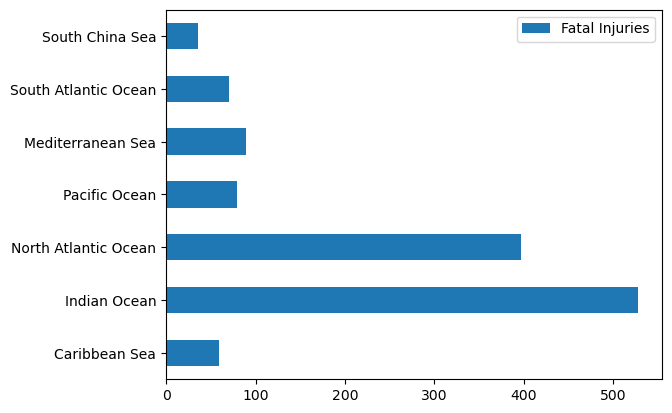

In [54]:
df1.plot.barh()

In [55]:
###   NOO    #####
# df_injuries = pd.concat([df_minor, df_dramatic, df_fatal], axis=1)
# df_injuries

### SIZE & SEAS/OCEANS - Sara

In [57]:
df_size_ocean = dfsara[['size', 'seas_oceans']]

In [58]:
len(df_size_ocean[(df_size_ocean["size"] == 'small shark (<2 m)') & (df_size_ocean["seas_oceans"] == 'Caribbean Sea')])

7

In [59]:
size_shark_small = {
    'Caribbean Sea': '7',
    'Indian Ocean': '204',
    'North Atlantic Ocean': '410',
    'Pacific Ocean': '10',
    'Mediterranean Sea': '15',
    'South Atlantic Ocean': '5',
    'South China Sea': '10',
    #'Solomon Sea': '1',
    #'Persian Gulf': '1'
}


size_shark_medium = {
    'Caribbean Sea': '10',
    'Indian Ocean': '297',
    'North Atlantic Ocean': '363',
    'Pacific Ocean': '44',
    'Mediterranean Sea': '51',
    'South Atlantic Ocean': '3',
    'South China Sea': '8',
    #'Solomon Sea': '4',
    #'Persian Gulf': '2'
}


size_shark_large = {
    'Caribbean Sea': '19',
    'Indian Ocean': '698',
    'North Atlantic Ocean': '693',
    'Pacific Ocean': '34',
    'Mediterranean Sea': '58',
    'South Atlantic Ocean': '45',
    'South China Sea': '15',
    #'Solomon Sea': '1',
    #'Persian Gulf': '10'
}

In [60]:
#Convert dictionaries to pandas Series
df_small = pd.Series(size_shark_small).astype(int)
df_medium = pd.Series(size_shark_medium).astype(int)
df_large = pd.Series(size_shark_large).astype(int)

In [61]:
DF1 = pd.DataFrame({
    'Small shark (<2 m)': df_small,
    'Medium shark (<5 m)': df_medium,
    'Large shark (>5 m)': df_large
})
DF1

,Small shark (<2 m),Medium shark (<5 m),Large shark (>5 m)
Caribbean Sea,7,10,19
Indian Ocean,204,297,698
North Atlantic Ocean,410,363,693
Pacific Ocean,10,44,34
Mediterranean Sea,15,51,58
South Atlantic Ocean,5,3,45
South China Sea,10,8,15


<Axes: >

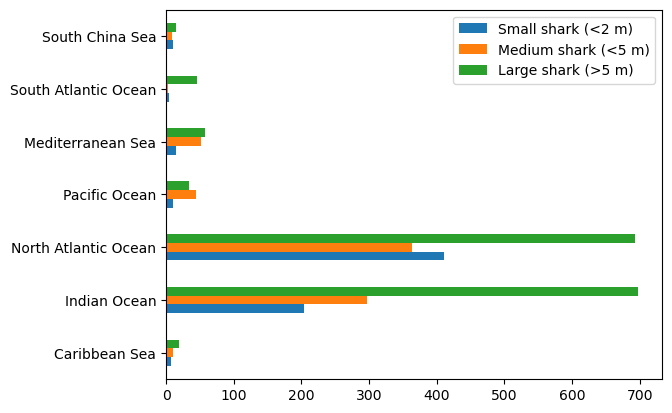

In [62]:
DF1.plot.barh()

### Size and type of injury - Sara

In [64]:
df_size_injury = dfsara[['size', 'injury']]

In [65]:
len(df_size_injury[(df_size_injury["size"] == 'large shark (>5 m)') & (df_size_injury["injury"] == 'Minor')])

335

In [66]:
size_small = {
    'Fatal': '23',
    'Dramatic': '404',
    'Minor': '224',
}


size_medium = {
    'Fatal': '65',
    'Dramatic': '505',
    'Minor': '229'
}


size_large = {
    'Fatal': '325',
    'Dramatic': '909',
    'Minor': '335'
}

In [67]:
#Convert dictionaries to pandas Series
df_small1 = pd.Series(size_small).astype(int)
df_medium1 = pd.Series(size_medium).astype(int)
df_large1 = pd.Series(size_large).astype(int)

In [68]:
DF2 = pd.DataFrame({
    'Small shark (<2 m)': df_small1,
    'Medium shark (<5 m)': df_medium1,
    'Large shark (>5 m)': df_large1
})
DF2

,Small shark (<2 m),Medium shark (<5 m),Large shark (>5 m)
Fatal,23,65,325
Dramatic,404,505,909
Minor,224,229,335


<Axes: >

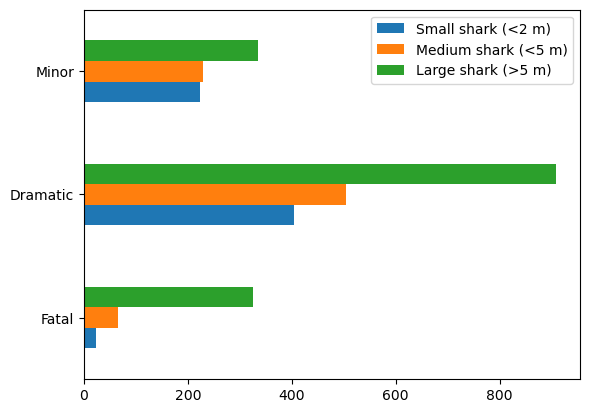

In [69]:
DF2.plot.barh()

In [70]:
df_size_injury

,size,injury
0,large shark (>5 m),Dramatic
1,large shark (>5 m),Dramatic
2,large shark (>5 m),Dramatic
3,large shark (>5 m),Dramatic
4,small shark (<2 m),Dramatic
...,...,...
6833,size unknown,Others
6834,large shark (>5 m),Others
6835,size unknown,Fatal
6836,size unknown,Dramatic


In [71]:
df1 = df_size_injury[(df_size_injury['size'] == 'large shark (>5 m)') & (df_size_injury['injury'] == 'Fatal')]
df1.value_counts()

size                injury
large shark (>5 m)  Fatal     325
Name: count, dtype: int64

<Axes: >

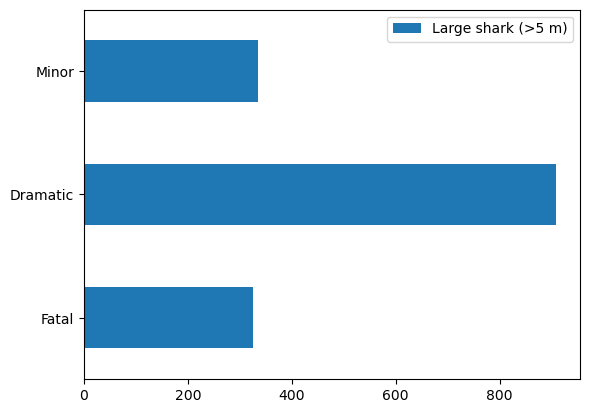

In [72]:
df1 = pd.DataFrame({
    'Large shark (>5 m)': df_large1
})
df1.plot.barh()

###  Percentage of Fatal Shark Attacks in the Most Popular Activities - Ruben

In [160]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [244]:
hl_df["activity"].value_counts()
#hl_df[hl_df["activity"] == "surfing"][:2]

activity
surfing          1432
fishing          1239
swimming         1215
diving            728
bathing           677
other             623
boat sports       499
watercraft        316
teasing shark      95
sand tiger         10
Name: count, dtype: int64

In [218]:
#  Percentage of Fatal Shark Attacks in surfing
ys_df_surfing = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "surfing") & (hl_df["injury"].isin(["Fatal"]))])
all = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "surfing")])

print(ys_df_surfing/all*100)

5.614973262032086


In [220]:
ys_df_surfing = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "fishing") & (hl_df["injury"].isin(["Fatal"]))])
all = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "fishing")])

print(ys_df_surfing/all*100)

7.7227722772277225


In [222]:
#  Percentage of Fatal Shark Attacks in swimming
ys_df_surfing = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "swimming") & (hl_df["injury"].isin(["Fatal"]))])
all = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "swimming")])

print(ys_df_surfing/all*100)

18.095238095238095


In [224]:
#  Percentage of Fatal Shark Attacks in diving
ys_df_surfing = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "diving") & (hl_df["injury"].isin(["Fatal"]))])
all = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "diving")])

print(ys_df_surfing/all*100)

18.361581920903955


In [226]:
#  Percentage of Fatal Shark Attacks in bathing
ys_df_surfing = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "bathing") & (hl_df["injury"].isin(["Fatal"]))])
all = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "bathing")])

print(ys_df_surfing/all*100)

3.3834586466165413


In [228]:
#  Percentage of Fatal Shark Attacks in other
ys_df_surfing = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "other") & (hl_df["injury"].isin(["Fatal"]))])
all = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "other")])

print(ys_df_surfing/all*100)

11.299435028248588


In [230]:
#  Percentage of Fatal Shark Attacks in teasing shark
ys_df_surfing = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "teasing shark") & (hl_df["injury"].isin(["Fatal"]))])
all = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "teasing shark")])

print(ys_df_surfing/all*100)

0.0


In [263]:
#  Percentage of Fatal Shark Attacks in boat sports
ys_df_surfing = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "boat sports") & (hl_df["injury"].isin(["Fatal"]))])
all = len(hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "boat sports")])

print(ys_df_surfing/all*100)

12.25296442687747


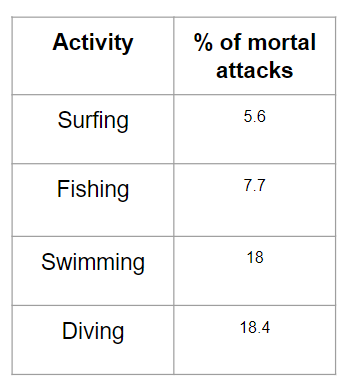

###  Number of shark attacks by year (since 1990) - Ruben

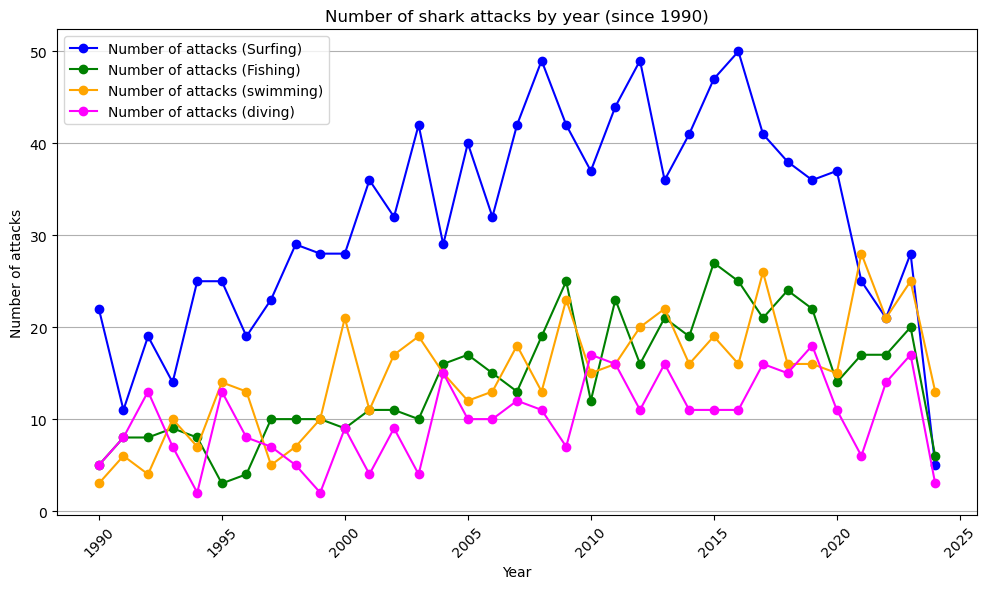

In [242]:
#filter for activity // number of shark attacks by year (since 1990)
ys_df_surfing = hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "surfing")]
ys_df_fishing = hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "fishing")]
ys_df_swimming = hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "swimming")]
ys_df_diving = hl_df[(hl_df["year"] >= 1990) & (hl_df["activity"] == "diving")]
#count attacks in year for activity 
ys_df_surfing_counts = ys_df_surfing['year'].value_counts().sort_index()
ys_df_fishing_counts = ys_df_fishing['year'].value_counts().sort_index()
ys_df_swimming_counts = ys_df_swimming['year'].value_counts().sort_index()
ys_df_diving_counts = ys_df_diving['year'].value_counts().sort_index()
#graphs
plt.figure(figsize=(10, 6))
plt.plot(ys_df_surfing_counts.index, ys_df_surfing_counts.values, color='blue', marker='o', label='Number of attacks (Surfing)')
plt.plot(ys_df_fishing_counts.index, ys_df_fishing_counts.values, color='green', marker='o', label='Number of attacks (Fishing)')
plt.plot(ys_df_swimming_counts.index, ys_df_swimming_counts.values, color='orange', marker='o', label='Number of attacks (swimming)')
plt.plot(ys_df_diving_counts.index, ys_df_diving_counts.values, color='magenta', marker='o', label='Number of attacks (diving)')
#tittle axis, lanes
plt.title('Number of shark attacks by year (since 1990)')
plt.xlabel('Year')
plt.ylabel('Number of attacks')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

###  Distribution of shark attacks by Age - Ruben

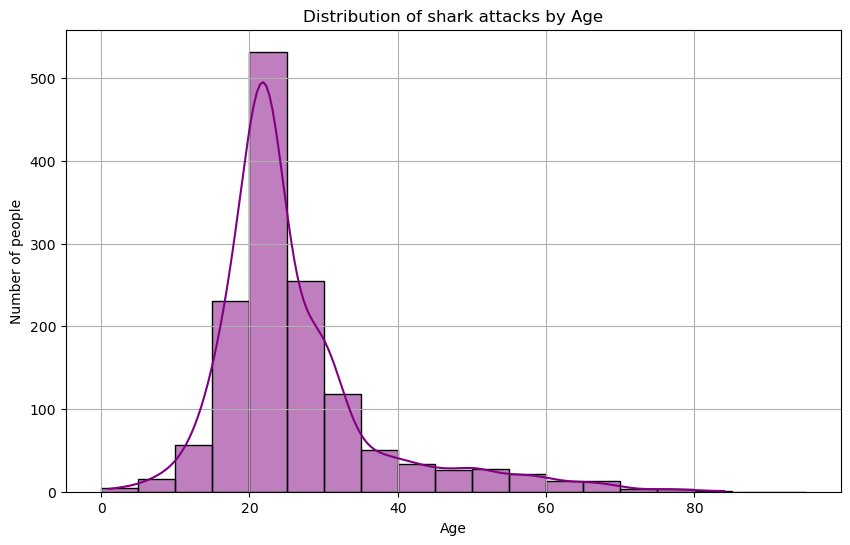

In [261]:
# Distribution of shark attacks by Age
a = hl_df[hl_df["injury"] == "Fatal"]
plt.figure(figsize=(10, 6))   
sns.histplot(data=a, x='age', bins=range(0, 100, 5), kde=True, color='purple') #red ?? better 
plt.title('Distribution of shark attacks by Age')
plt.xlabel('Age')  
plt.ylabel('Number of people')  
plt.grid(True)   
plt.show() 

### Stay Safe, Dive OK! - Ruben

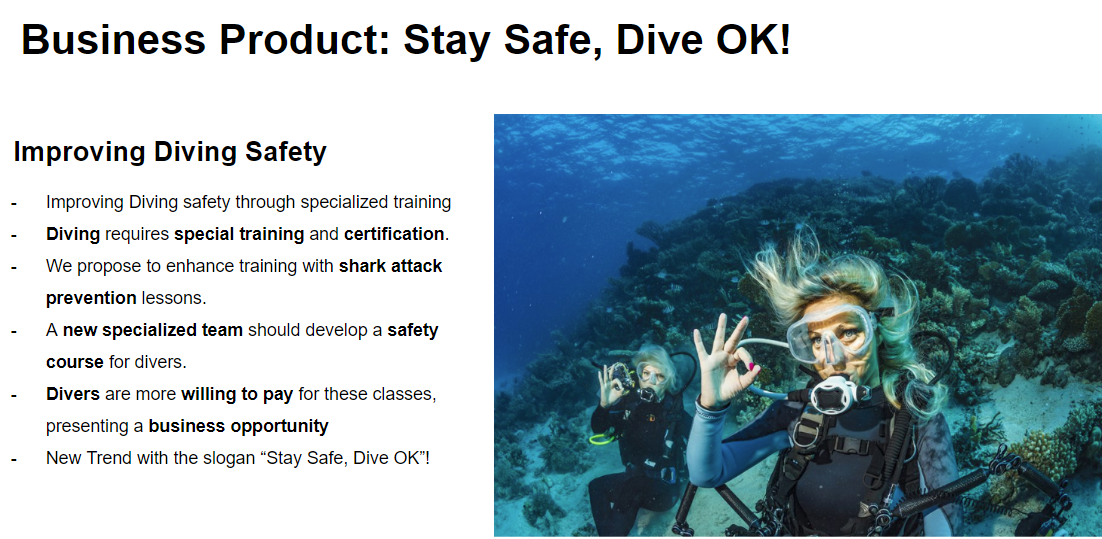

###   SUSANA

In [ ]:
# Group by year and count the number of attacks for males and females separately
males_attack_counts_1900 = males_only_1900.groupby('year').size().reset_index(name='Number of Attacks')
females_attack_counts_1900 = females_only_1900.groupby('year').size().reset_index(name='Number of Attacks')

males_attack_counts_1900['sex'] = 'Males'
females_attack_counts_1900['sex'] = 'Females'

combined_attack_counts = pd.concat([males_attack_counts_1900, females_attack_counts_1900])

plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='Number of Attacks', hue='sex', data=combined_attack_counts, marker='o')
plt.title('Number of Shark Attacks by Males and Females Over the Years 1900 to 2024')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.legend(title='Sex')
plt.grid(True)  # Add grid lines for better readability
plt.show()

In [ ]:
# Assuming 'ta_df' is already loaded in the environment

# Step 3: Filter for females and the desired year range (1900 to 2024)
females_only_1900 = ta_df[(ta_df['year'] >= 1500) & (ta_df['year'] <= 2024) & (ta_df['sex'] == 'F')]

# Step 4: Group by year and count the number of attacks for females only
females_attack_counts_1900 = females_only_1900.groupby('year').size().reset_index(name='Number of Attacks (Females)')

# Step 5: Drop NaN or missing values from both DataFrames

females_attack_counts_1900 = females_attack_counts_1900.dropna()  # Remove rows with NaNs from females data

# Step 6: Plot the line graphs for male and female shark attacks over the years
plt.figure(figsize=(12, 6))

# Line plot for the number of female attacks
sns.lineplot(x='year', y='Number of Attacks (Females)', data=females_attack_counts_1900, marker='s', dashes=False, label='Females')


# Add titles and labels
plt.title('Number of Shark Attacks by Females Over the Years 1900 to 2024 with Linear Regression')
plt.xlabel('Year')
plt.ylabel('Number of Attacks')
plt.legend()  # Show the legend
plt.grid(True)  # Add grid lines for better readability
plt.show()